# Anomaly detection for time series

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import math
import pandas as pd

from TSB_UAD.utils.max_mean_discrepancy import calculate_mmd
from TSB_UAD.utils.shapelets import calculate_shapelet_similarity
from TSB_UAD.utils.dtw import compute_dtw_distance

from TSB_UAD.models.distance import Fourier
from TSB_UAD.models.feature import Window
from TSB_UAD.utils.slidingWindows import find_length
from TSB_UAD.utils.visualisation import plotFig
from sklearn.preprocessing import MinMaxScaler
from TSB_UAD.vus.metrics import get_metrics

from TSB_UAD.models.iforest import IForest
from TSB_UAD.models.AE import AE_MLP2
from TSB_UAD.models.custom_lstm import CustomLstm
from TSB_UAD.models.lstm import lstm

##  Data preprocessing

Here we load and prepare the time series (here, we load only a snippet of 10,000 points). We automatically estimate the subsequence length for the anomaly detection methods that require a subsequence length parameter.
In order to do this, we use auto-correlation

In [2]:
# Prepare data for unsupervised method

filepath = 'data/TSB-UAD-Synthetic/MGAB_add_point_outlier_0.02/9.test.out'
df = pd.read_csv(filepath, header=None).dropna().to_numpy()

mgab_name = filepath.split('/')[-1]
max_length = 10000
starting_point = 0  # 40000

mgab_data = df[starting_point:starting_point+max_length,0].astype(float)
mgab_label = df[starting_point:starting_point+max_length,1].astype(int)
    
mgab_slidingWindow = find_length(mgab_data)
mgab_X_data = Window(window = mgab_slidingWindow).convert(mgab_data).to_numpy()

# Prepare data for semisupervised method. 
# Here, the training ratio = 0.1

mgab_data_train = mgab_data[:int(0.1*len(mgab_data))]
mgab_data_test = mgab_data

X_train = Window(window = mgab_slidingWindow).convert(mgab_data_train).to_numpy()
X_test = Window(window = mgab_slidingWindow).convert(mgab_data_test).to_numpy()

print("Estimated Subsequence length: ",mgab_slidingWindow)
print("Time series length: ",len(mgab_data))
print("Number of abnormal points: ",list(mgab_label).count(1))

Estimated Subsequence length:  49
Time series length:  10000
Number of abnormal points:  206


In [3]:
# plt.figure().set_figwidth(17)
# plt.plot(data, linewidth=1)
# plt.title('MGAB_filter_fft_11')
# plt.show()

# Dataset similarity

Here we are demonstrating and experimenting with datasets that we are trying to find their similarities between them

In [ ]:
filepath = 'data/TSB-UAD-Synthetic/YAHOO_add_point_outlier_0.02/Yahoo_A1real_16_data.out'
df2 = pd.read_csv(filepath, header=None).dropna().to_numpy()
yahoo_name = filepath.split('/')[-1]
max_length = 10000
# starting_point = 40000

yahoo_data = df2[:max_length,0].astype(float)
yahoo_label = df2[:max_length,1].astype(int)

yahoo_slidingWindow = find_length(yahoo_data)
yahoo_X_data = Window(window = yahoo_slidingWindow).convert(yahoo_data).to_numpy()

yahoo_data_train = yahoo_data[:int(0.1*len(yahoo_data))]
yahoo_data_test = yahoo_data

yahoo_X_train = Window(window = yahoo_slidingWindow).convert(yahoo_data_train).to_numpy()
yahoo_X_test = Window(window = yahoo_slidingWindow).convert(yahoo_data_test).to_numpy()

print("Estimated Subsequence length: ",yahoo_slidingWindow)
print("Time series length: ",len(yahoo_data))
print("Number of abnormal points: ",list(yahoo_label).count(1))

Estimated Subsequence length:  24
Time series length:  1420
Number of abnormal points:  47


Use Maximum Mean Discrepancy (MMD) with an RBF kernel to compute pairwise similarities between datasets.

In [5]:
mmd_value = calculate_mmd(mgab_data, yahoo_data, gamma=1.0)
print("MMD value:", mmd_value)

MMD value: 0.04883002546226867


Use Dynamic Time Warping (DTW) to find time series alignment/similarity

In [6]:
dtw_value = compute_dtw_distance(mgab_data, yahoo_data)
print("DTW value:", dtw_value)

DTW value: 2901.912


Shapelets are small, discriminative subsequences of a time series that can represent key patterns or features.

1. Extract shapelets from both datasets.
2. Calculate distances between shapelets from both datasets to measure similarity.

In [7]:
# shapelet_value = calculate_shapelet_similarity(data, data2)
# print('Shapelet similarity value:', shapelet_value)

## Display the results of anomaly detectors

For each output figure, the left panel shows the real time series with outliers (red), anomaly score obtained by each anomaly detector, and the correpsonding TP/FP/TN/FN classification. 

The right panel shows the ROC curve. AUC represents the area under the ROC curve. Larger AUC indicates better performance.

## 1. MGAB

AUC_ROC : 0.716
AUC_PR : 0.044
Precision : 0.082
Recall : 0.024
F : 0.037
Precision_at_k : 0.024
Rprecision : 0.077
Rrecall : 0.025
RF : 0.037
R_AUC_ROC : 0.952
R_AUC_PR : 0.86
VUS_ROC : 0.845
VUS_PR : 0.524
Affiliation_Precision : 0.572
Affiliation_Recall : 0.575


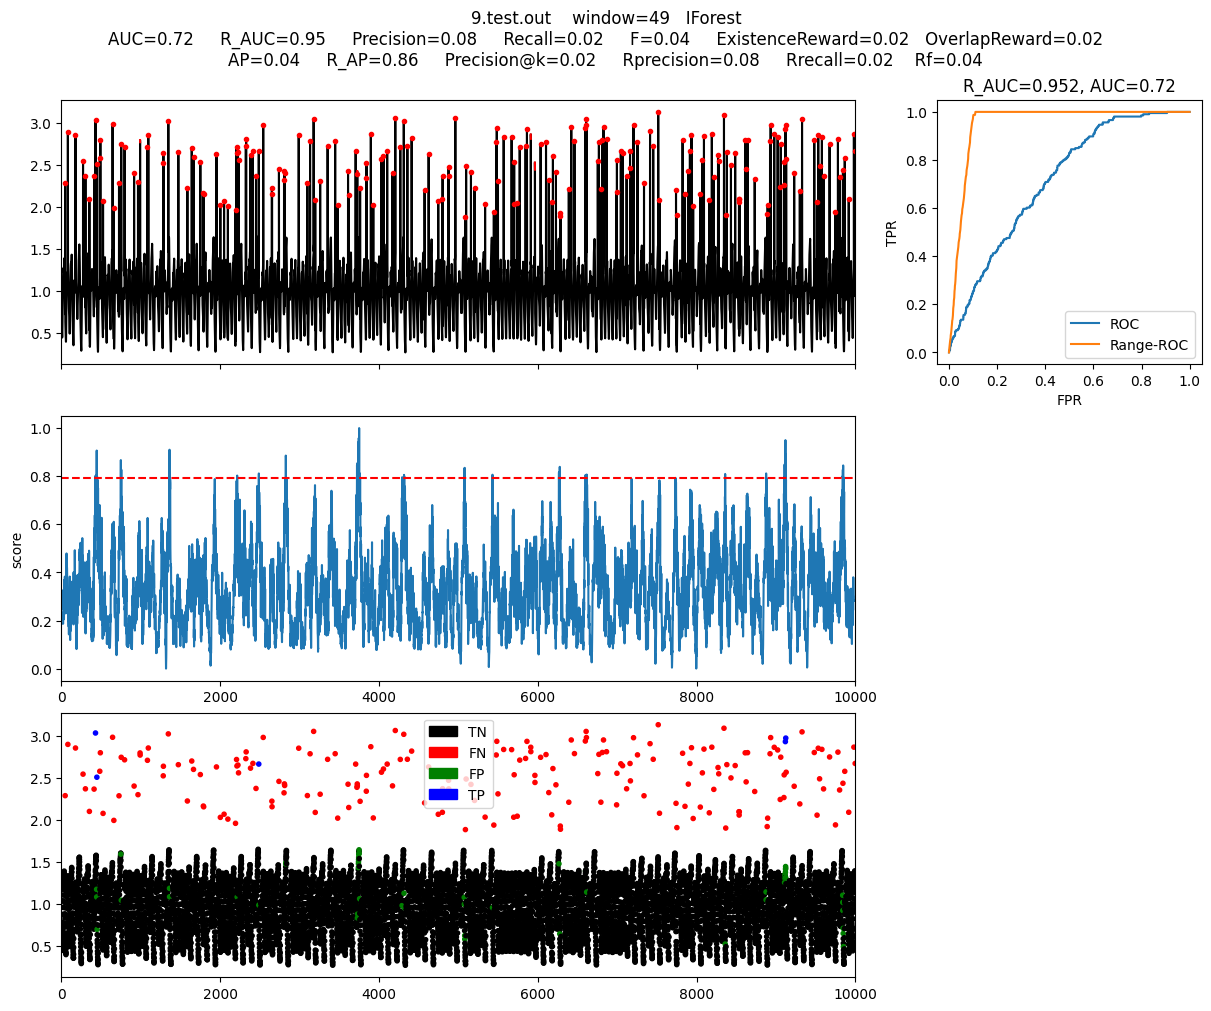

In [8]:
modelName='IForest'
mgab_if_clf = IForest(n_jobs=1)
x = mgab_X_data
mgab_if_clf.fit(x)

score = mgab_if_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((mgab_slidingWindow-1)/2) + list(score) + [score[-1]]*((mgab_slidingWindow-1)//2))

results = get_metrics(score, mgab_label, metric="all", slidingWindow=mgab_slidingWindow)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(mgab_data, mgab_label, score, mgab_slidingWindow, fileName=mgab_name, modelName=modelName) 

## 2. YAHOO

### a. IF with no pre training

AUC_ROC : 0.849
AUC_PR : 0.14
Precision : 0.241
Recall : 0.149
F : 0.184
Precision_at_k : 0.149
Rprecision : 0.279
Rrecall : 0.077
RF : 0.121
R_AUC_ROC : 0.974
R_AUC_PR : 0.911
VUS_ROC : 0.908
VUS_PR : 0.601
Affiliation_Precision : 0.652
Affiliation_Recall : 0.307


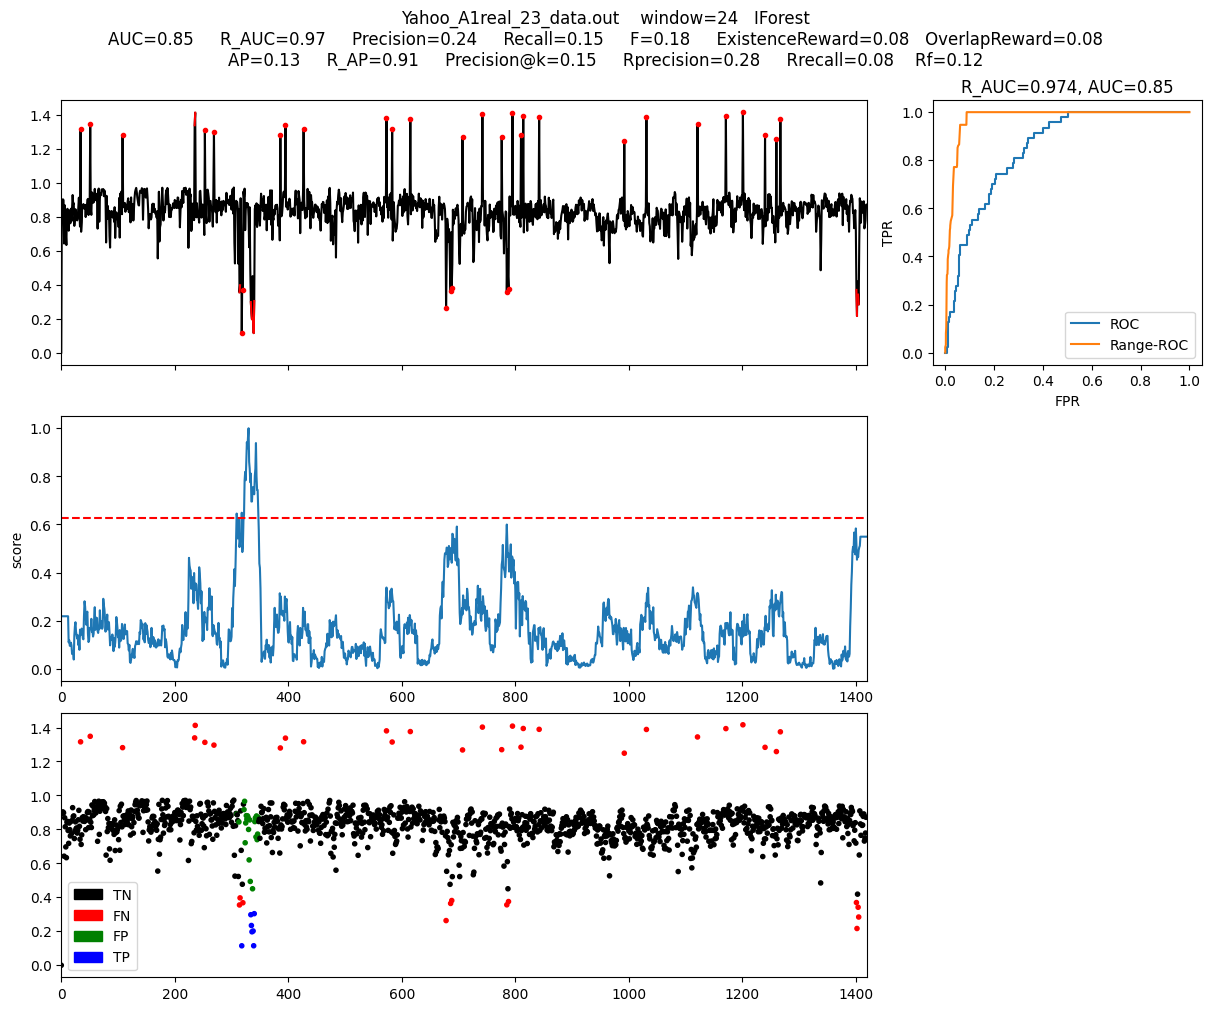

In [9]:
modelName='IForest'
yahoo_if_clf = IForest(n_jobs=1)
x = yahoo_X_data
yahoo_if_clf.fit(x)

score = yahoo_if_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((yahoo_slidingWindow-1)/2) + list(score) + [score[-1]]*((yahoo_slidingWindow-1)//2))

results = get_metrics(score, yahoo_label, metric="all", slidingWindow=yahoo_slidingWindow)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(yahoo_data, yahoo_label, score, yahoo_slidingWindow, fileName=yahoo_name, modelName=modelName) 

### b. IF with pre training

Due to the fact that it's pretrained, we must modify the Yahoo dataset with the lenght of the sliding window that was used for the MGAB dataset

In [10]:
yahoo_pre_trained_slidingWindow = mgab_slidingWindow
yahoo_pre_trained_X_data = Window(window = yahoo_pre_trained_slidingWindow).convert(yahoo_data).to_numpy()

yahoo_pre_trained_data_train = yahoo_data[:int(0.1*len(yahoo_data))]
yahoo_pre_trained_data_test = yahoo_data

yahoo_pre_trained_X_train = Window(window = yahoo_pre_trained_slidingWindow).convert(yahoo_data_train).to_numpy()
yahoo_pre_trained_X_test = Window(window = yahoo_pre_trained_slidingWindow).convert(yahoo_data_test).to_numpy()

print("Estimated Subsequence length: ",yahoo_pre_trained_slidingWindow)
print("Time series length: ",len(yahoo_data))
print("Number of abnormal points: ",list(yahoo_label).count(1))

Estimated Subsequence length:  49
Time series length:  1420
Number of abnormal points:  47


We are using the pre trained MGAB IF model on the Yahoo dataset to see if there are any improvements with the non pre trained model

AUC_ROC : 0.751
AUC_PR : 0.124
Precision : 0.226
Recall : 0.149
F : 0.179
Precision_at_k : 0.149
Rprecision : 0.068
Rrecall : 0.096
RF : 0.079
R_AUC_ROC : 0.935
R_AUC_PR : 0.858
VUS_ROC : 0.846
VUS_PR : 0.582
Affiliation_Precision : 0.58
Affiliation_Recall : 0.326


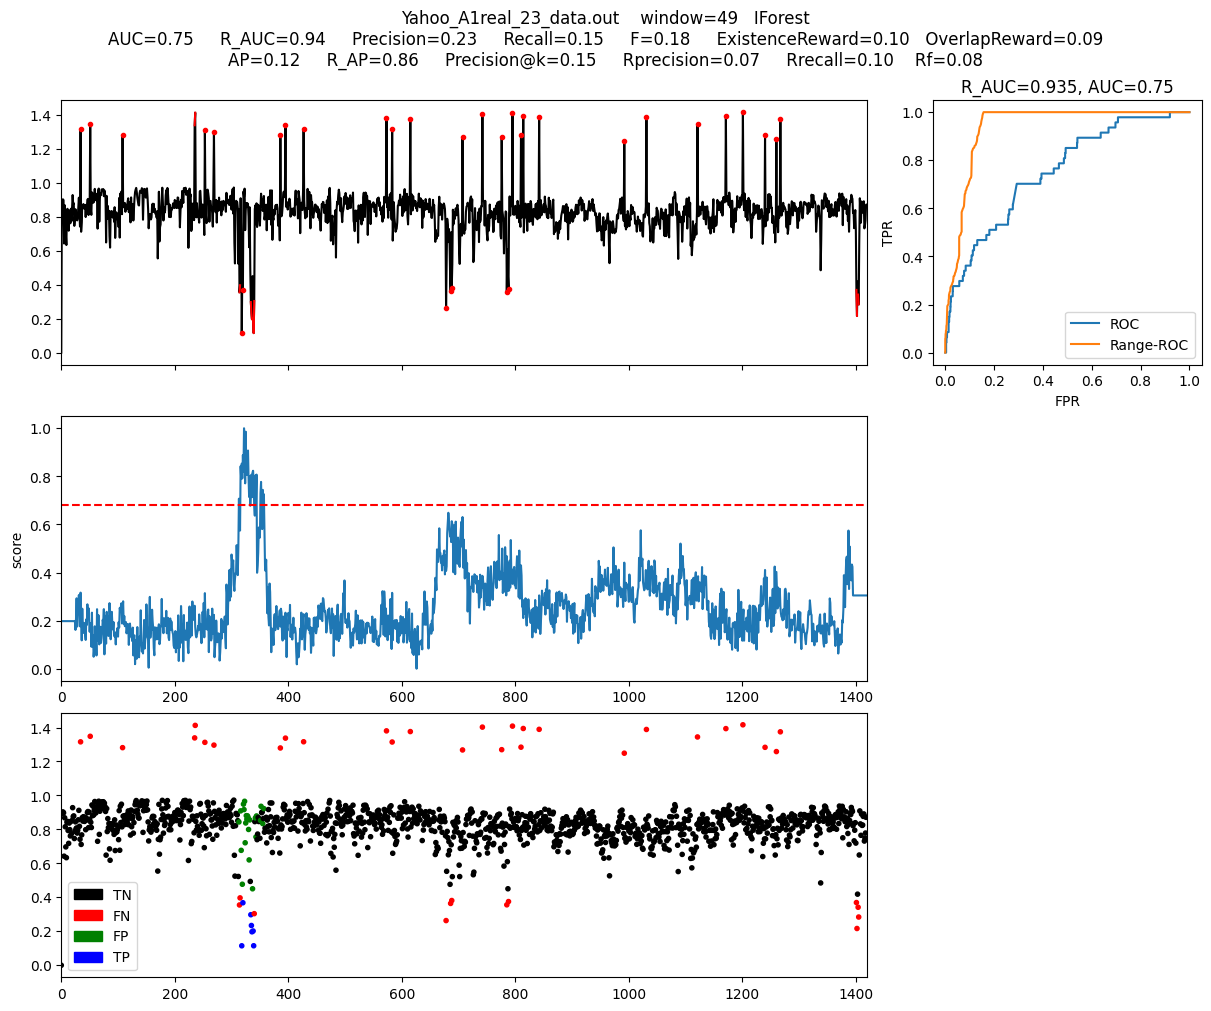

In [11]:
x = yahoo_pre_trained_X_test
mgab_if_clf.prediction(x)

score = mgab_if_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
score = np.array([score[0]]*math.ceil((yahoo_pre_trained_slidingWindow-1)/2) + list(score) + [score[-1]]*((yahoo_pre_trained_slidingWindow-1)//2))

results = get_metrics(score, yahoo_label, metric="all", slidingWindow=yahoo_pre_trained_slidingWindow)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(yahoo_data, yahoo_label, score, yahoo_pre_trained_slidingWindow, fileName=yahoo_name, modelName=modelName) 

# Custom AutoEncoder LSTM architecture

## 1. MGAB

311/311 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
AUC_ROC : 0.996
AUC_PR : 0.725
Precision : 0.805
Recall : 1.0
F : 0.892
Precision_at_k : 1.0
Rprecision : 0.993
Rrecall : 1.0
RF : 0.996
R_AUC_ROC : 0.884
R_AUC_PR : 0.694
VUS_ROC : 0.914
VUS_PR : 0.619
Affiliation_Precision : 0.997
Affiliation_Recall : 0.99


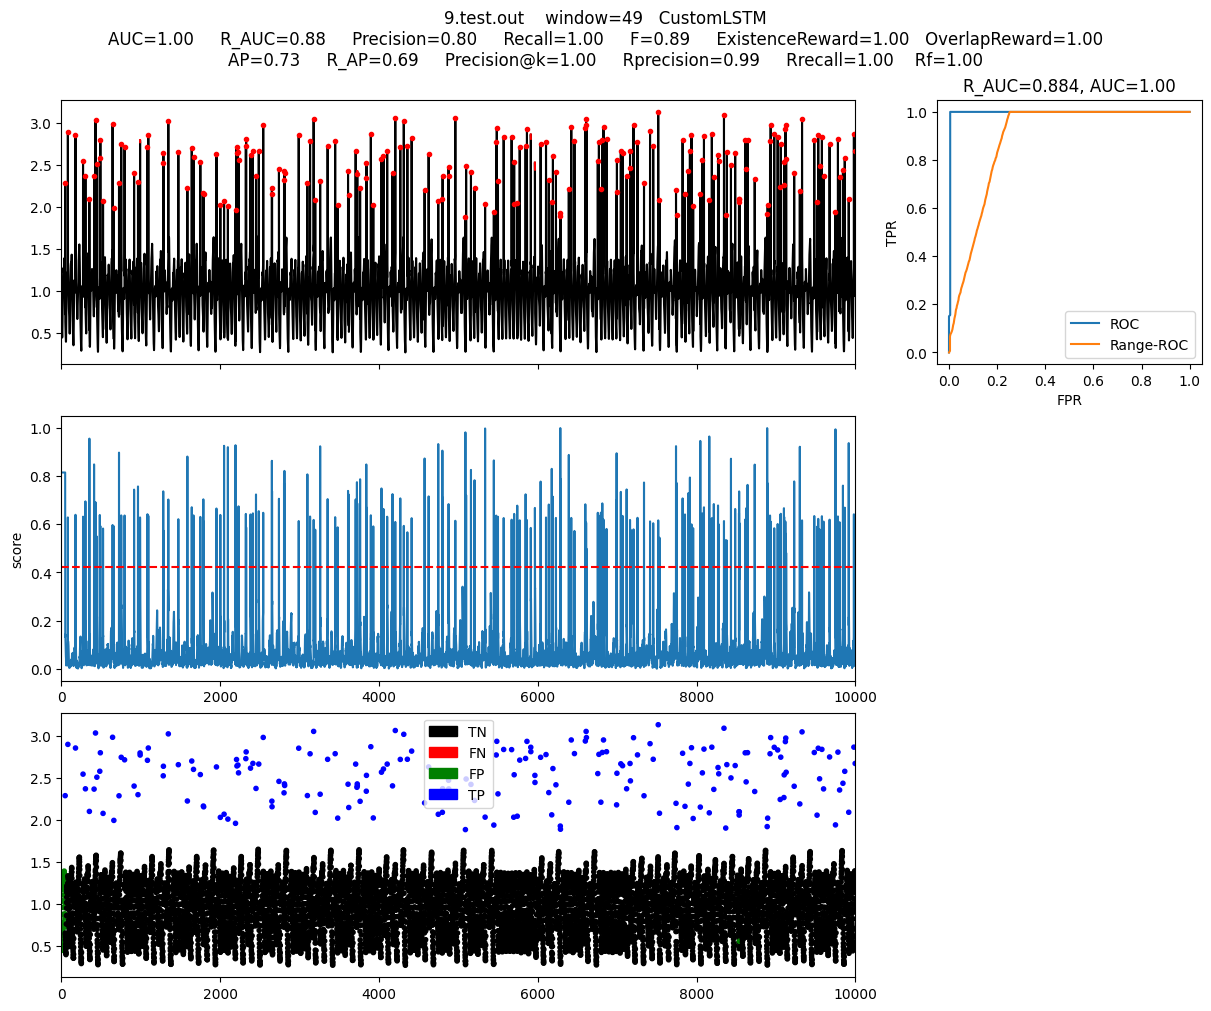

In [12]:
modelName='CustomLSTM'
mgab_lstm_clf = CustomLstm(slidingwindow = mgab_slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
mgab_lstm_clf.fit(mgab_data_train, mgab_data_test)
measure = Fourier()
measure.detector = mgab_lstm_clf
measure.set_param()
mgab_lstm_clf.decision_function(measure=measure)
        
score = mgab_lstm_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

# plotFig(data2, label2, score, slidingWindow2, fileName=name2, modelName=modelName)
results = get_metrics(score, mgab_label, metric="all", slidingWindow=mgab_slidingWindow)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(mgab_data, mgab_label, score, mgab_slidingWindow, fileName=mgab_name, modelName=modelName)

## 2. YAHOO
### a. LSTM with no pre training

Due to the fact that the Yahoo dataset creates a large window and during the training of the LSTM the dataset undergoes reshaping and a window larger than the reshaped time series cannot work, so we are using half the size of the original.

If the dataset was a larger one with a different window it would not have created such an issue.

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
AUC_ROC : 0.843
AUC_PR : 0.585
Precision : 0.0
Recall : 0.0
F : 0.0
Precision_at_k : 0.0
Rprecision : 0
Rrecall : 0.0
RF : 0
R_AUC_ROC : 0.719
R_AUC_PR : 0.341
VUS_ROC : 0.742
VUS_PR : 0.344
Affiliation_Precision : 0.545
Affiliation_Recall : 0.927


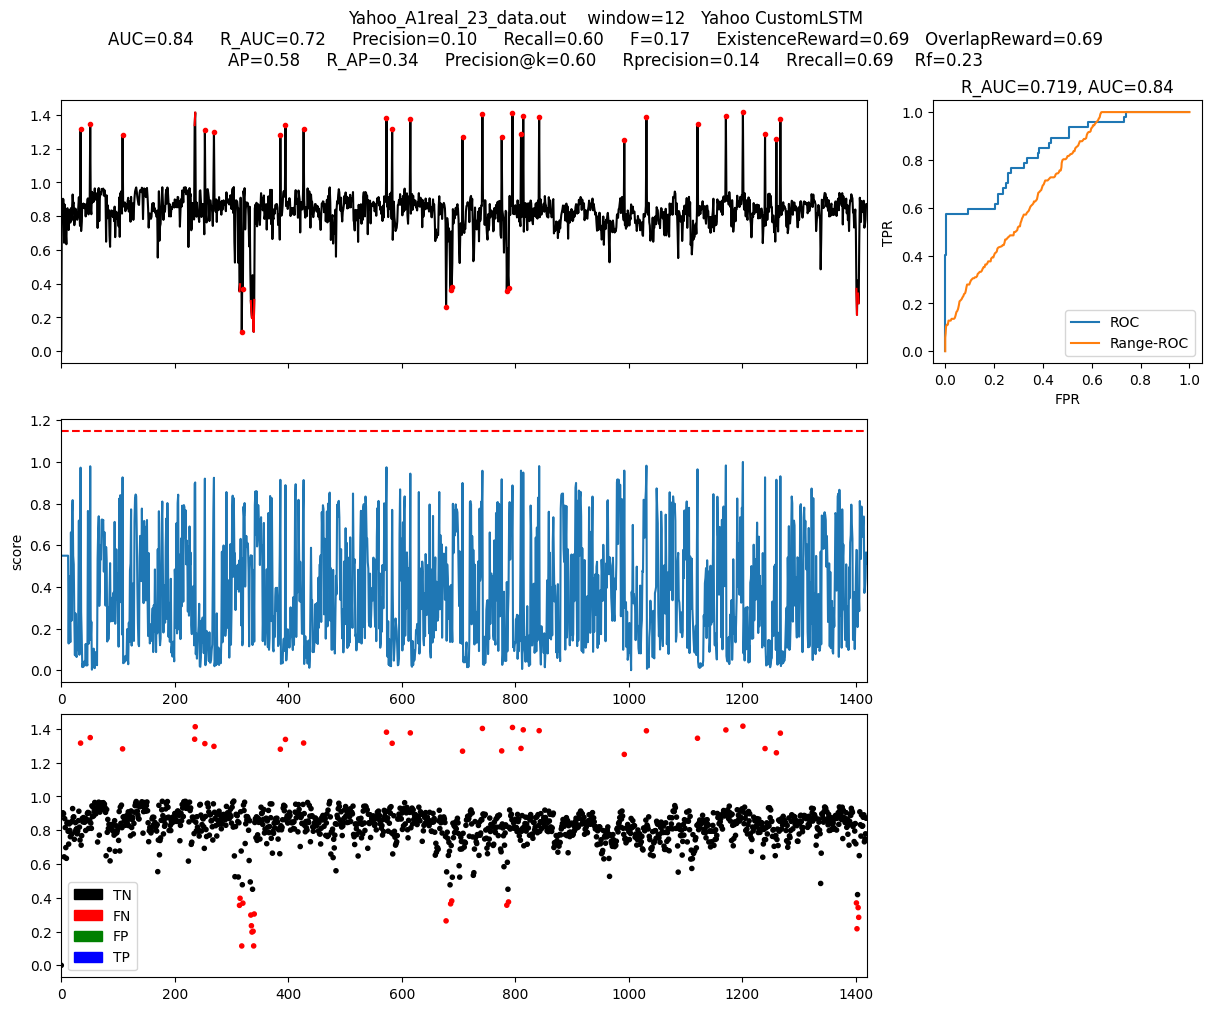

In [13]:
modelName='Yahoo CustomLSTM'
yahoo_lstm_clf = CustomLstm(slidingwindow = yahoo_slidingWindow//2, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
yahoo_lstm_clf.fit(yahoo_data_train, yahoo_data_test)
measure = Fourier()
measure.detector = yahoo_lstm_clf
measure.set_param()
yahoo_lstm_clf.decision_function(measure=measure)
        
score = yahoo_lstm_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

results = get_metrics(score, yahoo_label, metric="all", slidingWindow=yahoo_slidingWindow//2)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(yahoo_data, yahoo_label, score, yahoo_slidingWindow//2, fileName=yahoo_name, modelName=modelName)

### b. LSTM with pre training

On the other hand, with the pre trained LSTM we are not required to change the sliding window 

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
AUC_ROC : 0.926
AUC_PR : 0.499
Precision : 0.6
Recall : 0.574
F : 0.587
Precision_at_k : 0.574
Rprecision : 0.625
Rrecall : 0.641
RF : 0.633
R_AUC_ROC : 0.844
R_AUC_PR : 0.55
VUS_ROC : 0.859
VUS_PR : 0.466
Affiliation_Precision : 0.841
Affiliation_Recall : 0.776


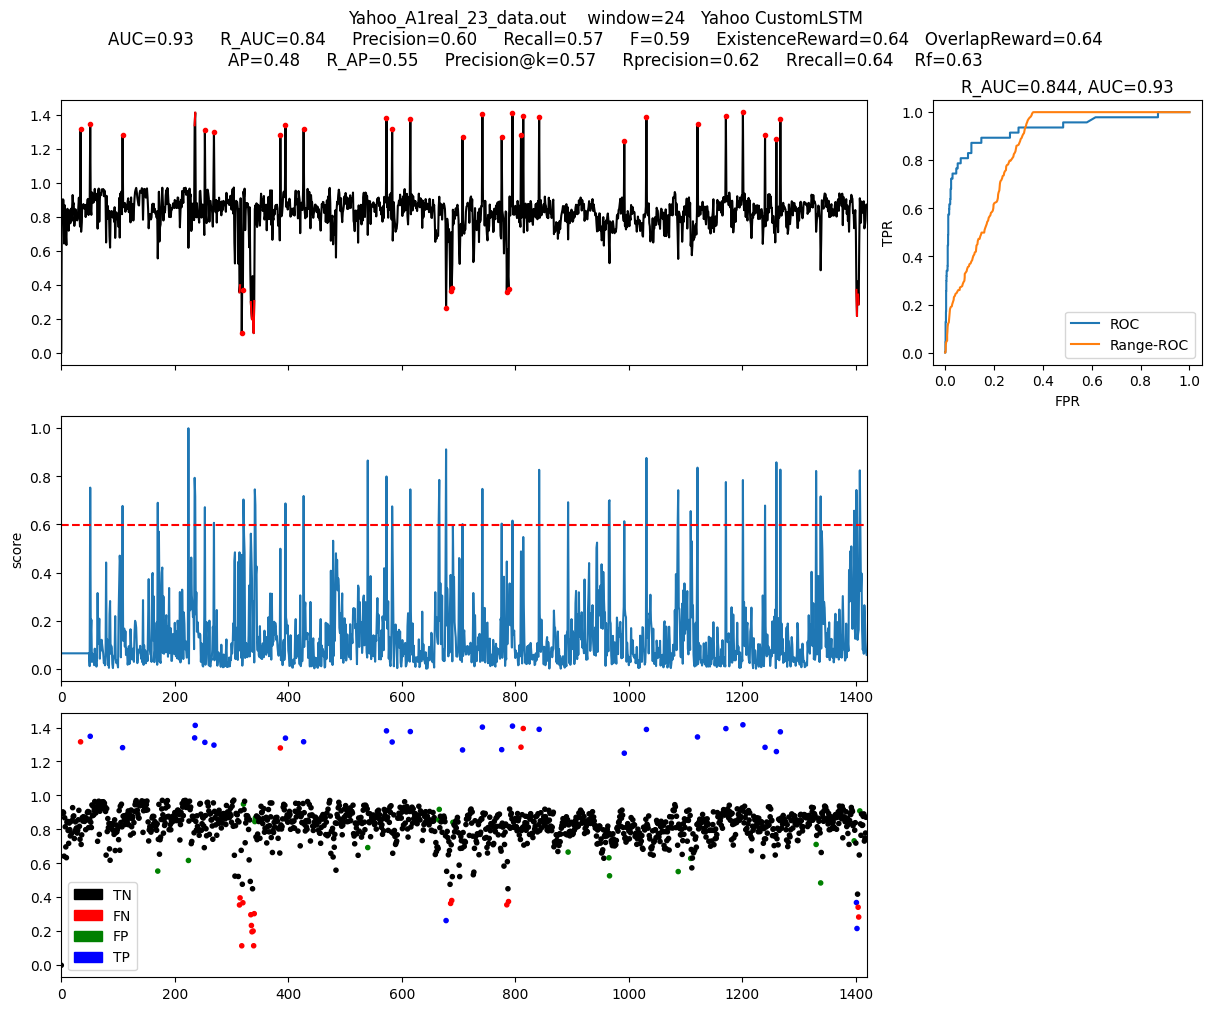

In [14]:
mgab_lstm_clf.prediction(yahoo_data_train, yahoo_data_test)
measure = Fourier()
measure.detector = mgab_lstm_clf
measure.set_param()
mgab_lstm_clf.decision_function(measure=measure)
        
score = mgab_lstm_clf.decision_scores_
score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()

results = get_metrics(score, yahoo_label, metric="all", slidingWindow=yahoo_slidingWindow)
for metric in results.keys():
    print(metric, ':', round(results[metric],3))

plotFig(yahoo_data, yahoo_label, score, yahoo_slidingWindow, fileName=yahoo_name, modelName=modelName)

Default AutoEncoder with comprised of MLP neurons

In [15]:
# modelName='AE'  # AutoEncoder MLP
# clf = AE_MLP2(slidingWindow = mgab_slidingWindow, epochs=100, verbose=0)
# 
# clf.fit(mgab_data_train, mgab_data_test)
#         
# score = clf.decision_scores_
# score = MinMaxScaler(feature_range=(0,1)).fit_transform(score.reshape(-1,1)).ravel()
# 
# plotFig(mgab_data, mgab_label, score, mgab_slidingWindow, fileName=mgab_name, modelName=modelName)

Default LSTM architecture

In [16]:
# modelName='LSTM'
# clf = lstm(slidingwindow = mgab_slidingWindow, predict_time_steps=1, epochs = 50, patience = 5, verbose=0)
# clf.fit(mgab_data_train, mgab_data_test)
# measure = Fourier()
# measure.detector = clf
# measure.set_param()
# clf.decision_function(measure=measure)
#         
# plotFig(mgab_data, mgab_label, score, mgab_slidingWindow, fileName=mgab_name, modelName=modelName)